In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("husl")
sns.set_style("whitegrid")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
#dataset = "initial"
dataset = "final"
references_algorithms = ["Boost Kruskal", "Boost Prim"]

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [3]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]
for ref in references_algorithms:
    reference_times = df[(df.Algorithm == ref) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']
    df[f'{ref} speedup'] = df.apply(lambda x: reference_times[x.Graph] / x.time if x.Graph in reference_times.index else None , 1)
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

In [4]:
s = df[["Algorithm", "Graph", "Max threads", "speedup", "time"]]\
    .groupby(("Graph", "Algorithm", "Max threads"))\
    .agg(["median", "std"])
s.time.to_csv(f"summaries/{dataset}/time_summary.csv")
s.time.to_latex(f"summaries/{dataset}/time_summary.tex")
s.speedup.to_csv(f"summaries/{dataset}/speedup_summary.csv")
s.speedup.to_latex(f"summaries/{dataset}/speedup_summary.tex")

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [5]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Boost Kruskal speedup,Boost Prim speedup,speedup
id,,,,,,,,,,,,
0,Filter Kruskal,1890815,USA-road-d.,1,0,2.507285e+06,0,"(USA-road-d., 1890815)",3.988377e-07,4.263171,1.502995,1.112288
0,Filter Kruskal,1890815,USA-road-d.,1,1,2.793596e+06,1,"(USA-road-d., 1890815)",3.579616e-07,3.826247,1.348955,0.998292
0,Filter Kruskal,1890815,USA-road-d.,1,2,2.716799e+06,1,"(USA-road-d., 1890815)",3.680802e-07,3.934404,1.387087,1.026511
0,Filter Kruskal,1890815,USA-road-d.,1,3,2.903089e+06,0,"(USA-road-d., 1890815)",3.444607e-07,3.681936,1.298078,0.960640
0,Filter Kruskal,1890815,USA-road-d.,1,4,2.746420e+06,1,"(USA-road-d., 1890815)",3.641104e-07,3.891971,1.372127,1.015440


In [6]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput,Boost Kruskal speedup,Boost Prim speedup,speedup
id,,,,,,,,,,,,
0,Filter Kruskal,321270,USA-road-d.,32,25,1.394634e+06,3,"(USA-road-d., 321270)",7.170339e-07,0.770198,0.396484,0.314462
0,Filter Kruskal,321270,USA-road-d.,32,26,1.340913e+06,3,"(USA-road-d., 321270)",7.457606e-07,0.801055,0.412369,0.327060
0,Filter Kruskal,321270,USA-road-d.,32,27,1.339608e+06,3,"(USA-road-d., 321270)",7.464868e-07,0.801835,0.412770,0.327379
0,Filter Kruskal,321270,USA-road-d.,32,28,1.317299e+06,0,"(USA-road-d., 321270)",7.591293e-07,0.815415,0.419761,0.332923
0,Filter Kruskal,321270,USA-road-d.,32,29,1.339790e+06,3,"(USA-road-d., 321270)",7.463856e-07,0.801726,0.412714,0.327334


In [7]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [8]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [9]:
summary

time                \
                                                  median          mean   
Algorithm          Max threads Graph nodes                               
Boost Kruskal      1           100000       2.738367e+06  2.791760e+06   
                               264346       9.357669e+05  9.316892e+05   
                               321270       1.074145e+06  1.061800e+06   
                               1207945      5.670941e+06  5.642300e+06   
                               1890815      1.068899e+07  1.066158e+07   
                   2           100000       2.783658e+06  2.783172e+06   
                               264346       9.143416e+05  9.309334e+05   
                               321270       1.037850e+06  1.075206e+06   
                               1207945      6.097031e+06  6.086711e+06   
                               1890815      1.149022e+07  1.160316e+07   
                   4           100000       2.861776e+06  2.947624e+06   
                               264346       9.350470e+05  9.381006e+05   
                               321270       1.082376e+06  1.086450e+06   
                               1207945      6.300840e+06  6.290761e+06   
                               1890815      1.196396e+07  1.203739e+07   
                   6           100000       2.909005e+06  2.922326e+06   
                   8           100000       2.959996e+06  2.962125e+06   
                               264346       9.630653e+05  9.672136e+05   
                               321270       1.109695e+06  1.114780e+06   
                               1207945      6.437904e+06  6.451885e+06   
                               1890815      1.241150e+07  1.250269e+07   
                   10          100000       3.021514e+06  3.026434e+06   
                   12          100000       3.054561e+06  3.050054e+06   
                   14          100000       3.077174e+06  3.071252e+06   
                   16          100000       3.103238e+06  3.096885e+06   
                               264346       1.002161e+06  1.010948e+06   
                               321270       1.151785e+06  1.153053e+06   
                               1207945      6.622648e+06  6.623525e+06   
                               1890815      1.249739e+07  1.253494e+07   
                   18          100000       3.116878e+06  3.113676e+06   
...                                                  ...           ...   
Sequential Kruskal 4           264346       3.650331e+05  3.674694e+05   
                               321270       4.500117e+05  4.624253e+05   
                               1207945      1.485286e+06  1.527143e+06   
                               1890815      2.459885e+06  2.559643e+06   
                   6           100000       9.058078e+05  9.106076e+05   
                   8           100000       9.002885e+05  8.904310e+05   
                               264346       3.557764e+05  3.616117e+05   
                               321270       4.447884e+05  4.450744e+05   
                               1207945      1.458899e+06  1.506048e+06   
                               1890815      2.370492e+06  2.402278e+06   
                   10          100000       9.032219e+05  9.488450e+05   
                   12          100000       8.823583e+05  8.960491e+05   
                   14          100000       8.764380e+05  8.816511e+05   
                   16          100000       8.669130e+05  9.008768e+05   
                               264346       3.508995e+05  3.550481e+05   
                               321270       4.403338e+05  4.397143e+05   
                               1207945      1.426381e+06  1.429862e+06   
                               1890815      2.255034e+06  2.280520e+06   
                   18          100000       8.776922e+05  9.452972e+05   
                   20          100000       8.850836e+05  9.101266e+05   
                   22          100000       8.718732e+05

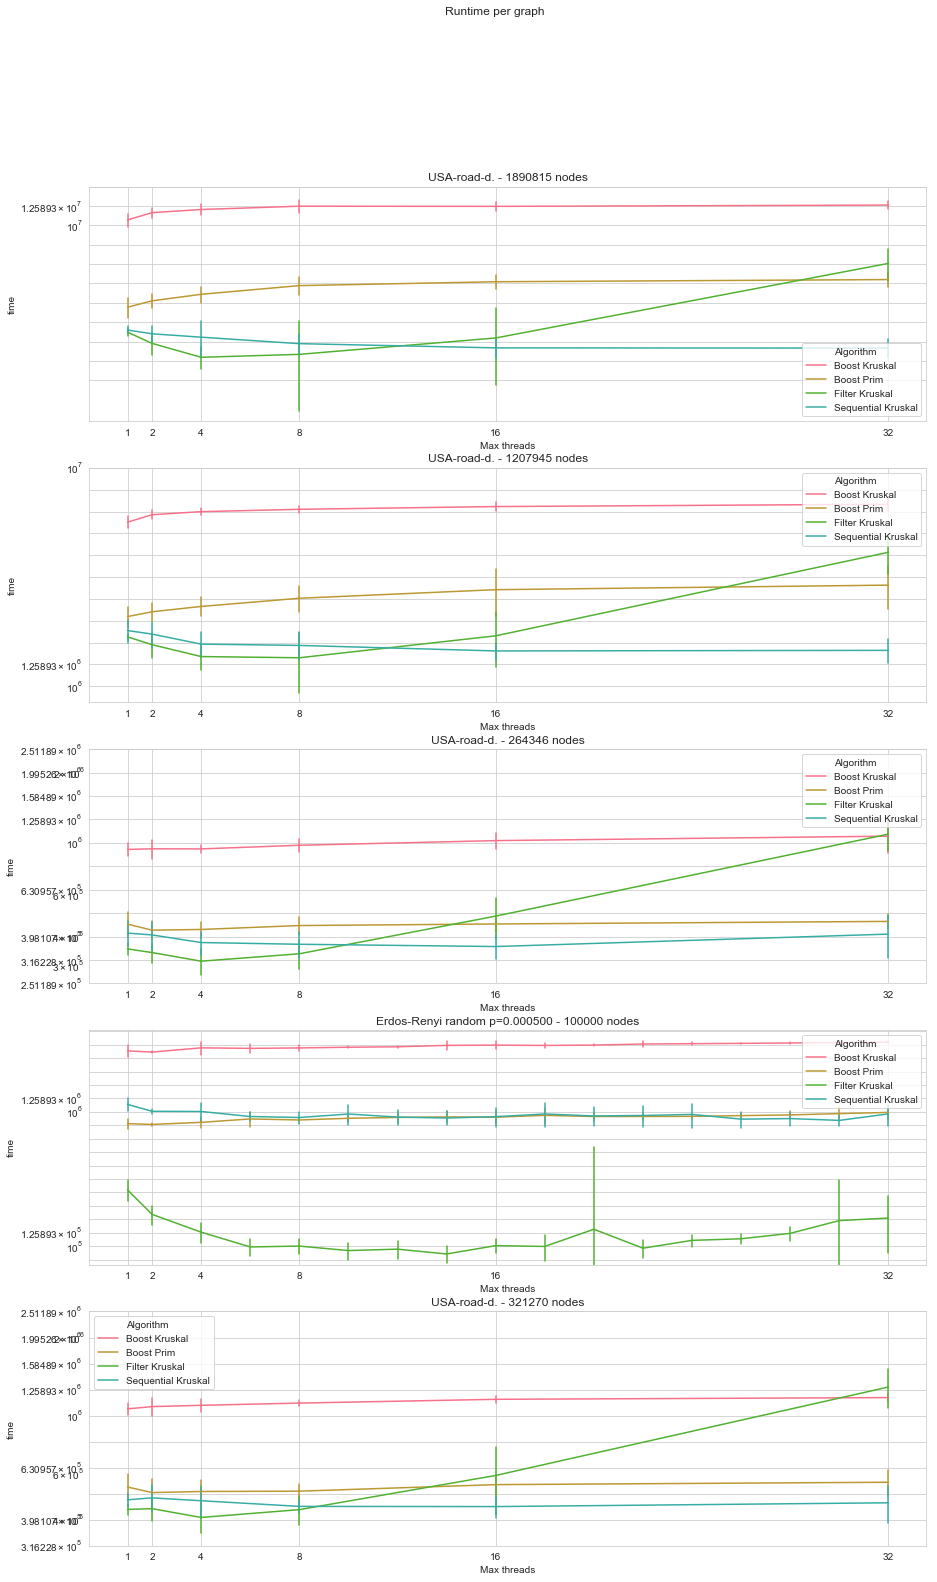

In [10]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/Graph_runtime.png", dpi=450)
plt.show()

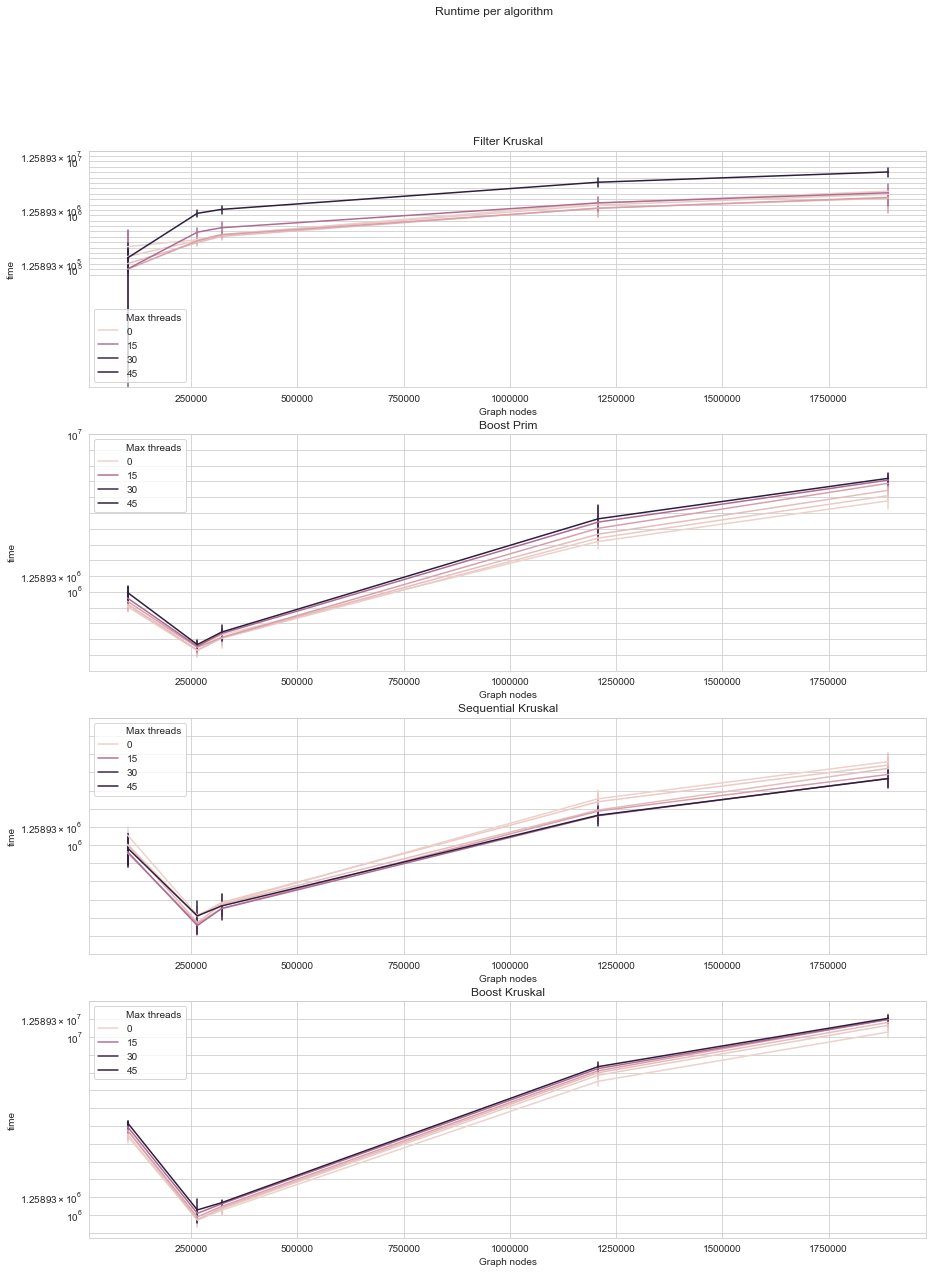

In [11]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi,
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df["Algorithm"].values == e]["time"]), np.max(df[df["Algorithm"].values == e]["time"])])
    axi.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    axi.set_title(f"{e}")
plt.suptitle("Runtime per algorithm")
fig.savefig(f"figures/{dataset}/AlgoRuntime.png", dpi=450)
plt.show()

In [12]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


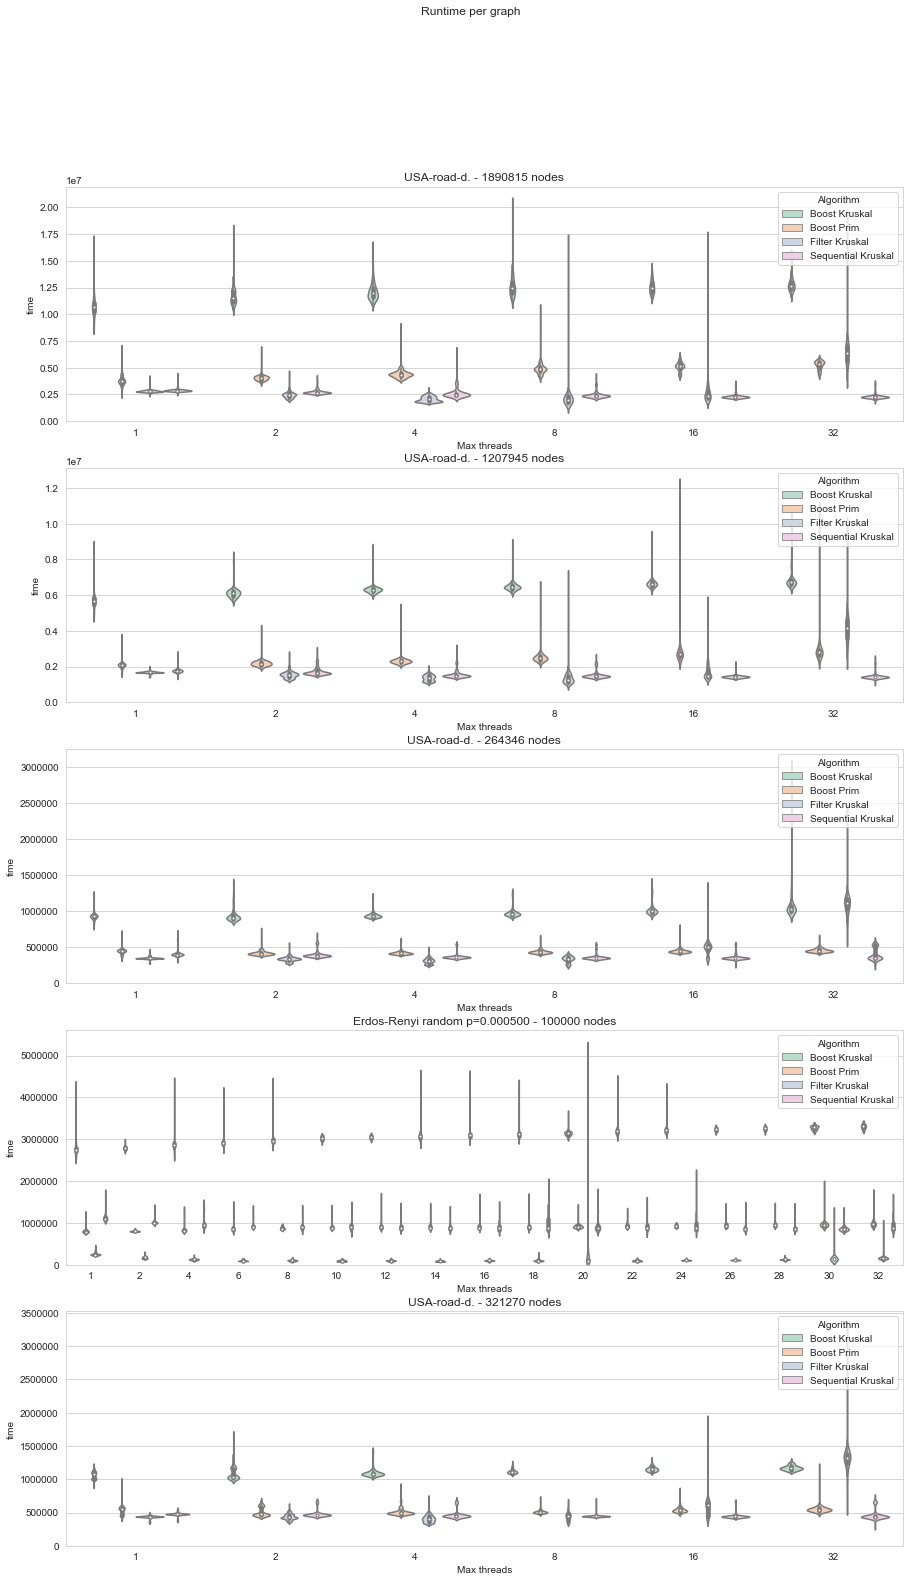

In [13]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/ViolinRuntime.png", dpi=450)
plt.show()

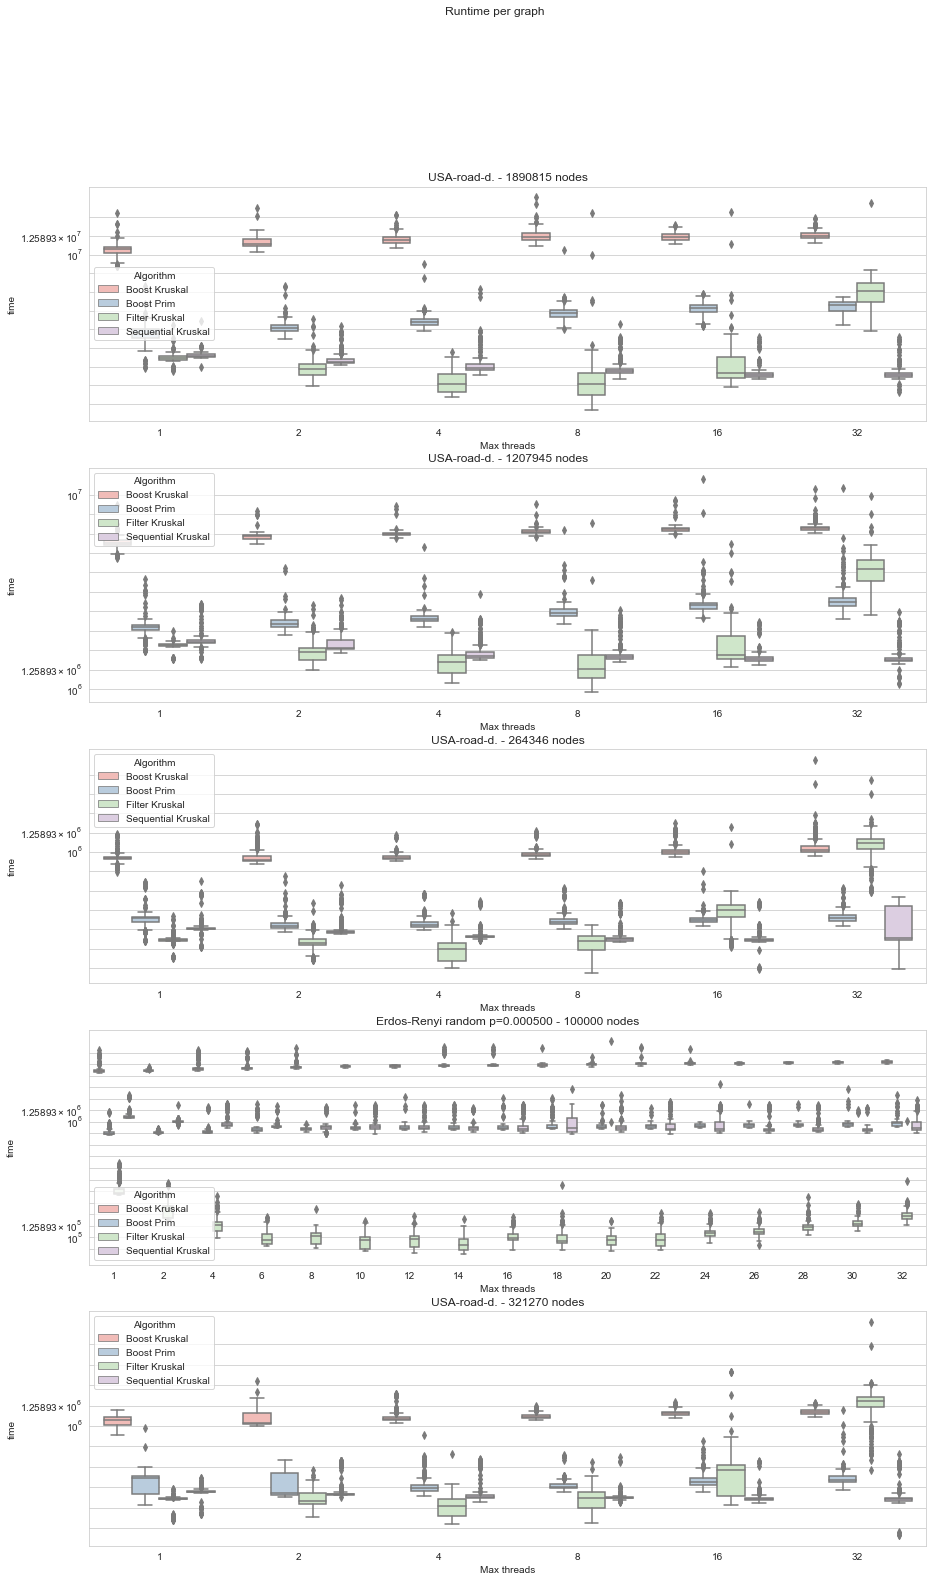

In [14]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/BoxRuntime.png", dpi=450)
plt.show()

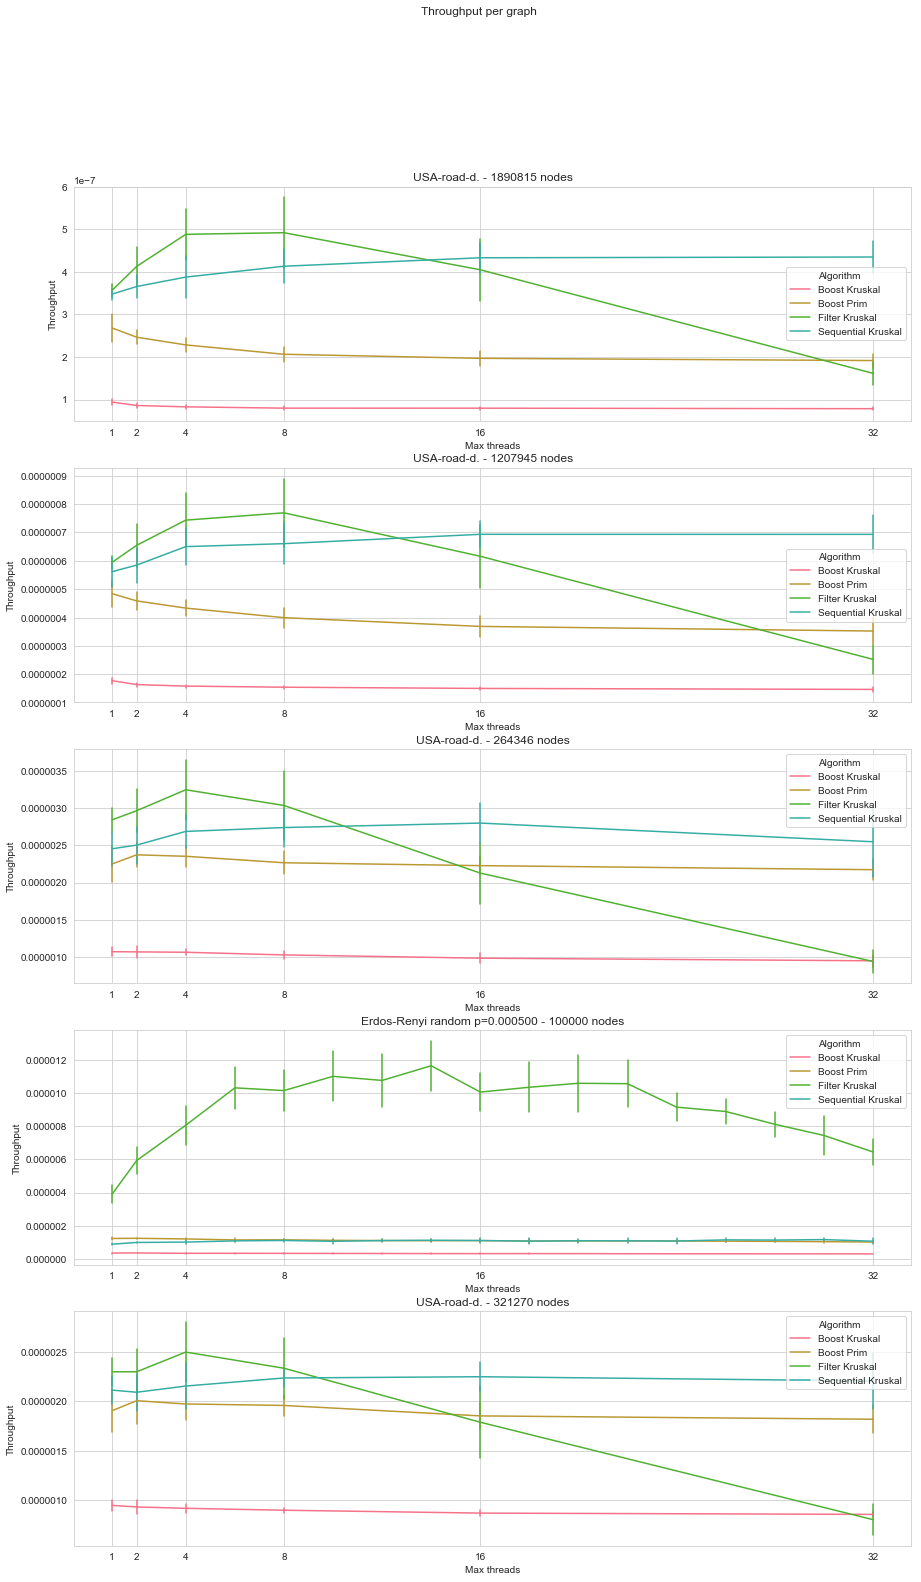

In [15]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Throughput per graph")
fig.savefig(f"figures/{dataset}/Throughput.png", dpi=450)
plt.show()

``` python
fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi, 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="Reference speedup", 
        hue="Max threads",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(0,)
plt.suptitle(f"Speedup per graph against {reference_algorithm}")
r_name = reference_algorithm.replace(' ', '_')
fig.savefig(f"figures/{dataset}/Speedup_against_{r_name}.png", dpi=450)
plt.show()
```

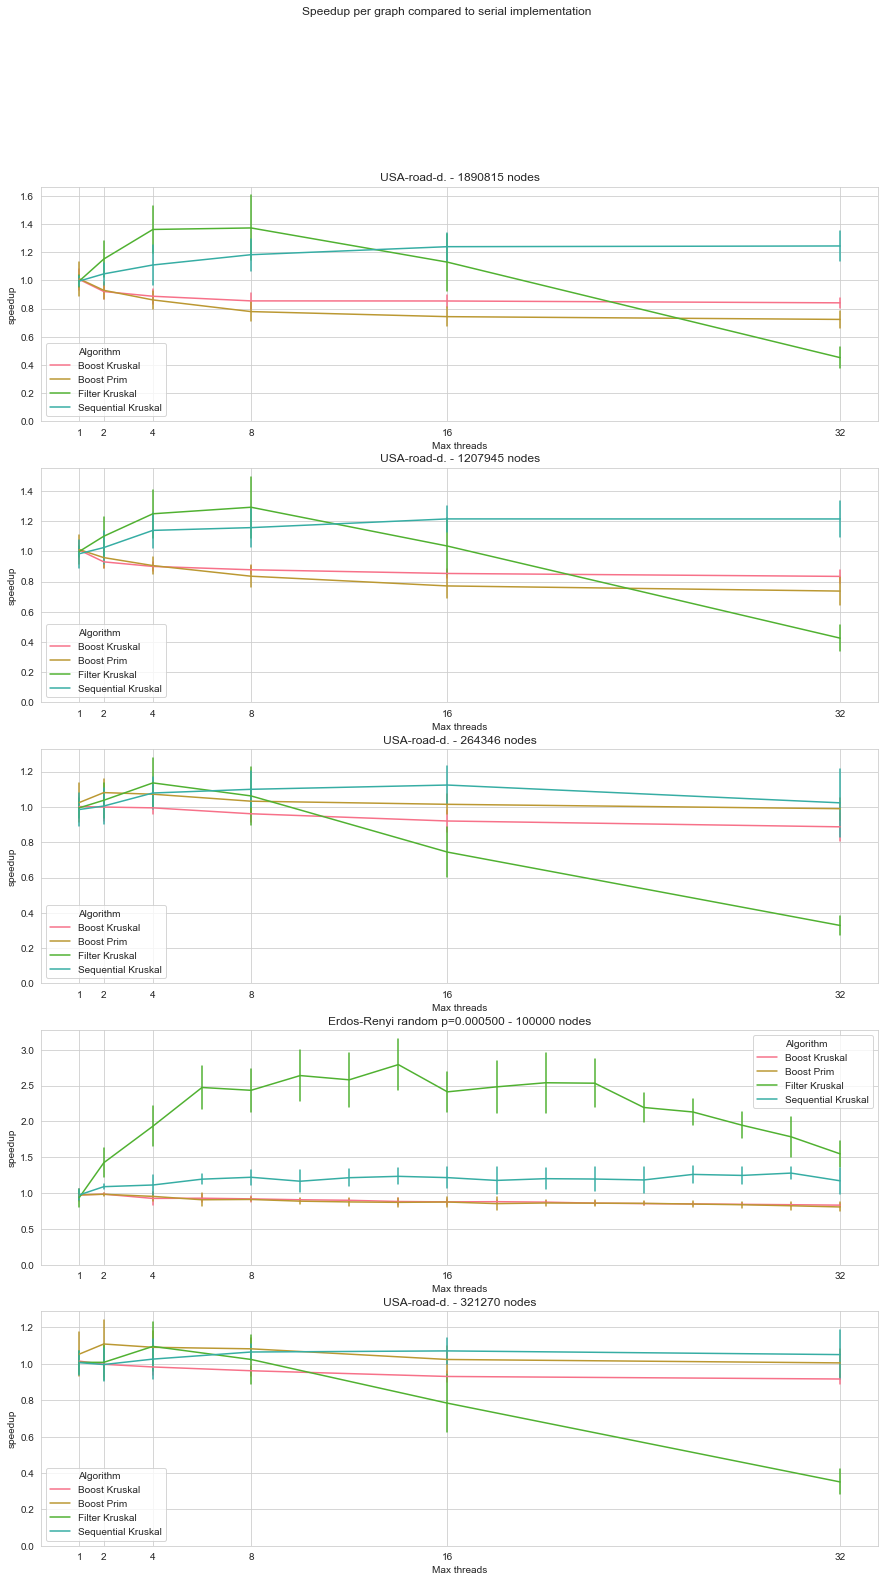

In [16]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_xticks(2**np.arange(0, 6, 1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle(f"Speedup per graph compared to serial implementation")
fig.savefig(f"figures/{dataset}/Speedup.png", dpi=450)
plt.show()

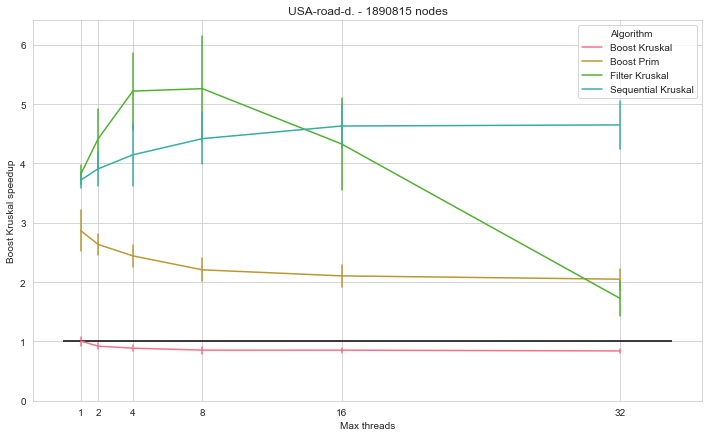

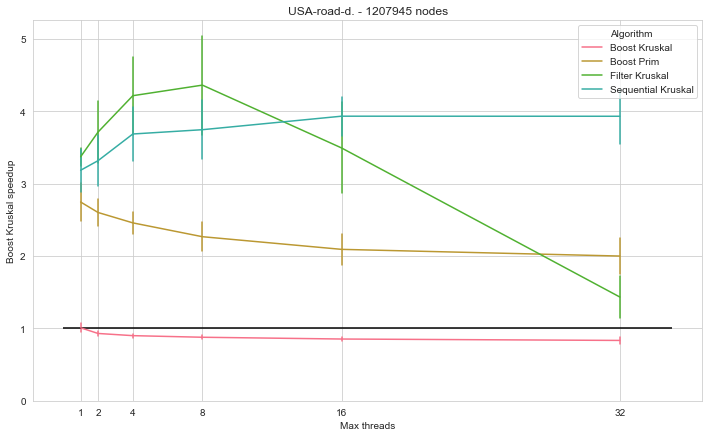

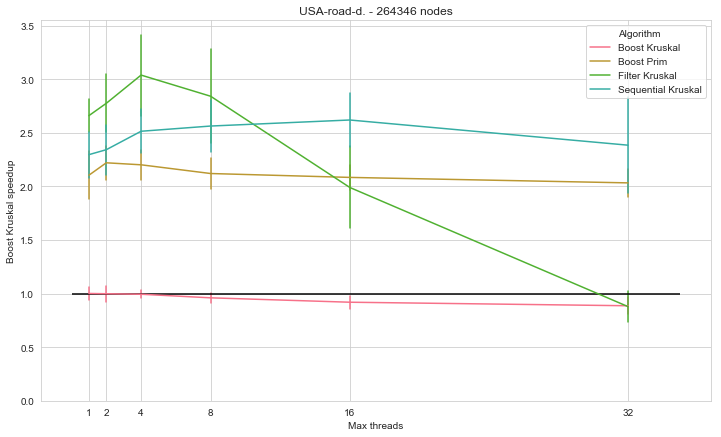

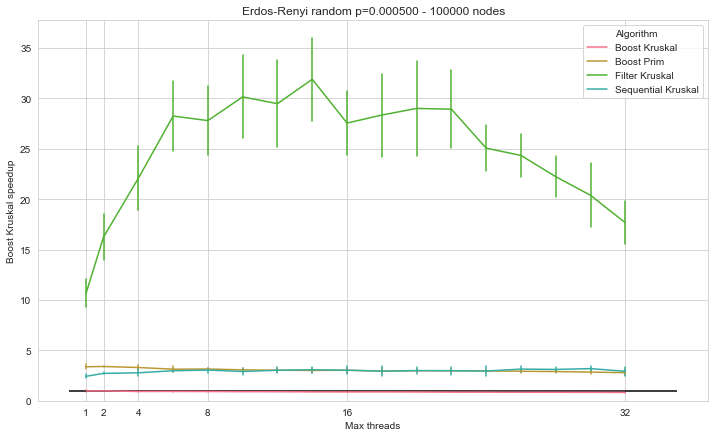

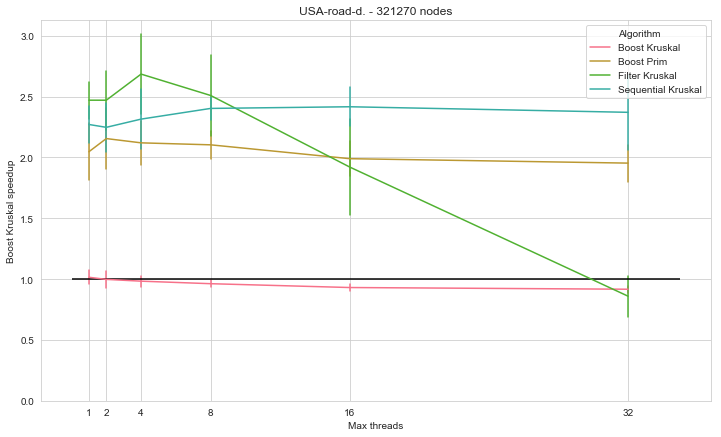

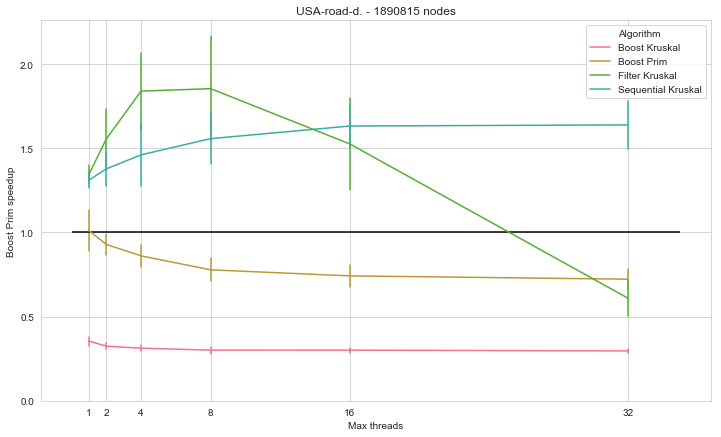

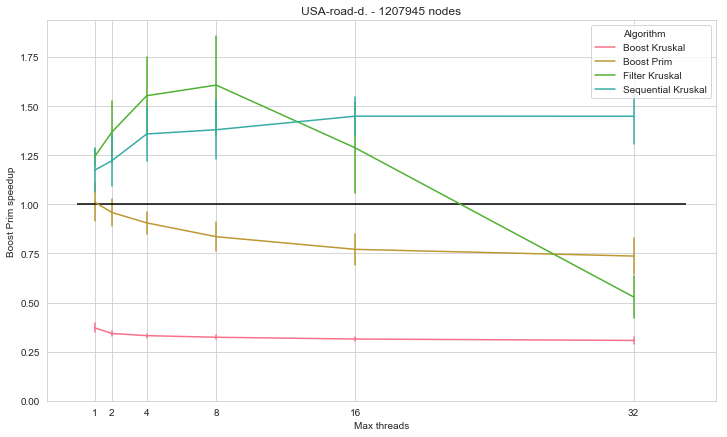

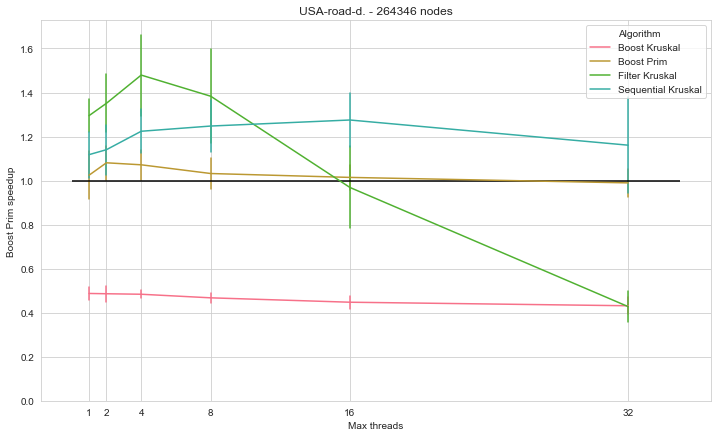

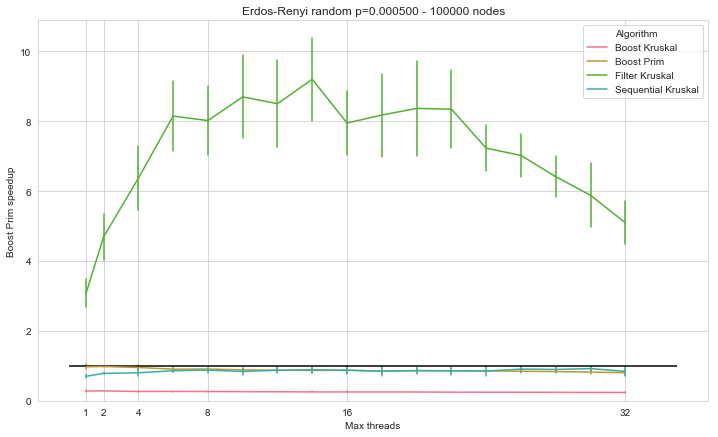

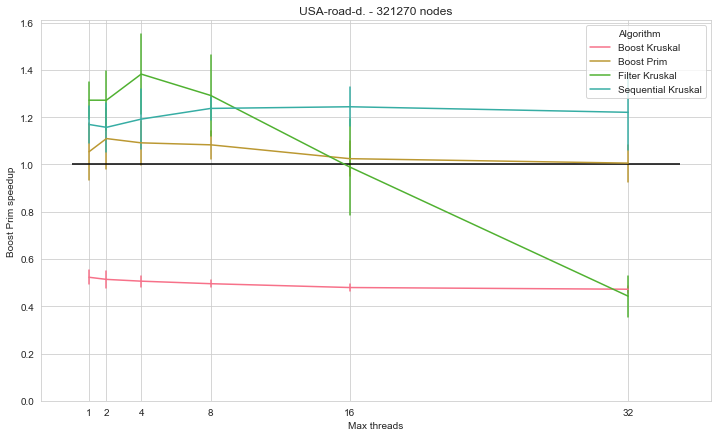

In [17]:
for ref_alg in references_algorithms:
    for i, e in enumerate(df.Graph.unique()):
        fig, ax = plt.subplots(figsize=(12, 7))
        #e = ('Preferential attachment 50 edges per vertice', 100000)
        sns.lineplot(
            ax=ax, 
            data=df[df.Graph == e], 
            x="Max threads", 
            y=f"{ref_alg} speedup", 
            hue="Algorithm",
            ci="sd",
            err_style="bars",
        )#.set(yscale="log")
        plt.hlines(y=1, xmin=0, xmax=35)
        ax.set_xticks(2**np.arange(0, 6, 1))
        ax.set_title(f"{e[0]} - {e[1]} nodes")
        ax.set_ylim(0,)
        fig.savefig(f"../presentations/final/graphics/{ref_alg.replace(' ', '')}Speedup{i}.png", dpi=450)
        plt.show()